## Step 1: Install Required Libraries
First, install the necessary libraries using pip:

In [ ]:
!pip install transformers datasets matplotlib seaborn

## Step 2: Import Libraries
Import the essential packages for handling datasets, tokenizing text, and building models:

In [2]:

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score


## Step 3: Load the SST-2 Dataset
The SST-2 (Stanford Sentiment Treebank) dataset can be easily accessed using the Hugging Face `datasets` library.

In [3]:
dataset = load_dataset('glue', 'sst2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

## Step 4: Load Tokenizer and Model
Use the DistilBERT model, a lighter version of BERT, for sentiment analysis.

In [4]:

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Step 5: Tokenize the Dataset
Tokenize the sentences using the tokenizer for efficient input processing.

In [5]:

def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

train_dataset = dataset['train'].map(tokenize_function, batched=True)
val_dataset = dataset['validation'].map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

## Step 6: Define Training Arguments
Configure the training parameters like batch size, epochs, and logging.

In [11]:

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to=[]
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Step 7: Define Accuracy Metric
Create a simple function to calculate accuracy.

In [12]:

def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=1)
    return {"accuracy": accuracy_score(labels, preds)}


## Step 8: Incorporate an Attention Mechanism
To visualize attention, we can extract attention scores from the model.

In [14]:

def get_attention_scores(text):
    inputs = tokenizer(text, return_tensors='pt').to(model.device)
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions
    return attentions

attention_scores = get_attention_scores("I absolutely loved this movie!")
print(attention_scores[-1].shape)


torch.Size([1, 12, 8, 8])


## Step 9: Train the Model
Train the model using the Hugging Face `Trainer` class.

In [15]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.183400,0.290450,0.901376
2,0.116900,0.430382,0.889908
3,0.061400,0.376522,0.904817


TrainOutput(global_step=12630, training_loss=0.1286105259391682, metrics={'train_runtime': 2252.8796, 'train_samples_per_second': 89.684, 'train_steps_per_second': 5.606, 'total_flos': 6691160124062208.0, 'train_loss': 0.1286105259391682, 'epoch': 3.0})

## Step 10: Save and Load the Fine-Tuned Model
After training, save the fine-tuned model for future use.

In [16]:

model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.txt',
 './fine_tuned_model/added_tokens.json')

## Step 11: Evaluate the Model
Run predictions on the validation set to evaluate model performance.

In [18]:
def evaluate():
    model.eval()
    with torch.no_grad():
        # Only pass input_ids and attention_mask to the model
        inputs = {k: v.to('cuda') for k, v in val_dataset[:].items() if k in ['input_ids', 'attention_mask']}
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    accuracy = accuracy_score(val_dataset[:]['label'], predictions)
    print(f"Validation Accuracy: {accuracy:.4f}")

evaluate()


Validation Accuracy: 0.9014


## Step 13: Test a Sample and Visualize Attention
You can test a sample sentence to predict its sentiment and visualize the attention weights.

Sentence: I absolutely loved this movie!
Predicted Sentiment: Positive


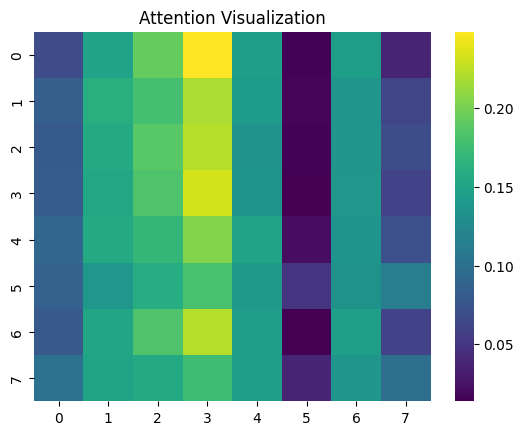

Sentence: I didn't enjoy the movie
Predicted Sentiment: Negative
Sentence: I loved this movie
Predicted Sentiment: Positive
Sentence: I hated this movie
Predicted Sentiment: Negative


In [32]:
def predict_and_visualize(text):
    inputs = tokenizer(text, return_tensors='pt').to(model.device)
    outputs = model(**inputs, output_attentions=True)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Sentence: {text}\nPredicted Sentiment: {sentiment}")

    attention_scores = outputs.attentions[-1].squeeze(0).mean(0).detach().cpu().numpy()
    sns.heatmap(attention_scores, cmap='viridis')
    plt.title('Attention Visualization')
    plt.show()

def predict(text):
    inputs = tokenizer(text, return_tensors='pt').to(model.device)
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Sentence: {text}\nPredicted Sentiment: {sentiment}")


predict_and_visualize("I absolutely loved this movie!")
predict("I didn't enjoy the movie")
predict("I loved this movie")
predict("I hated this movie")